In [1]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-11-04 06:32:42--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.206.102, 173.194.206.139, 173.194.206.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.206.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-11-04 06:32:42--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  66.9MB/s    in 0.3s    

2025-11-04 

In [2]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 8.9 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
from pyod.utils.example import visualize
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.ocsvm import OCSVM
from sklearn.metrics import precision_recall_curve, roc_curve, auc


In [8]:
X_train, X_test, y_train, y_test = generate_data(
    n_train=200, n_test=100, n_features=2, contamination=0.1, random_state=42
)


In [10]:
models = {
    'LOF': LOF(contamination=0.1),
    'KNN': KNN(contamination=0.1),
    'IForest': IForest(contamination=0.1),
    'OCSVM': OCSVM(contamination=0.1),
  #  'AutoEncoder': AutoEncoder(hidden_neurons=[64, 32, 32, 64], epochs=30, batch_size=32, contamination=0.1)
}

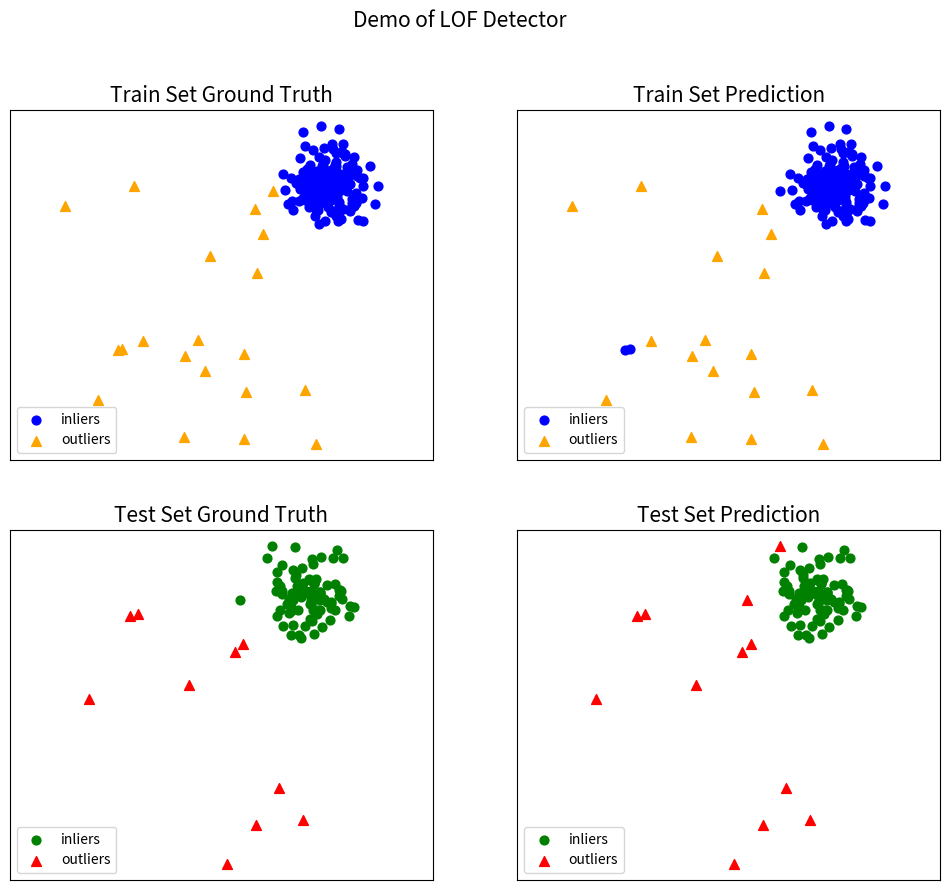

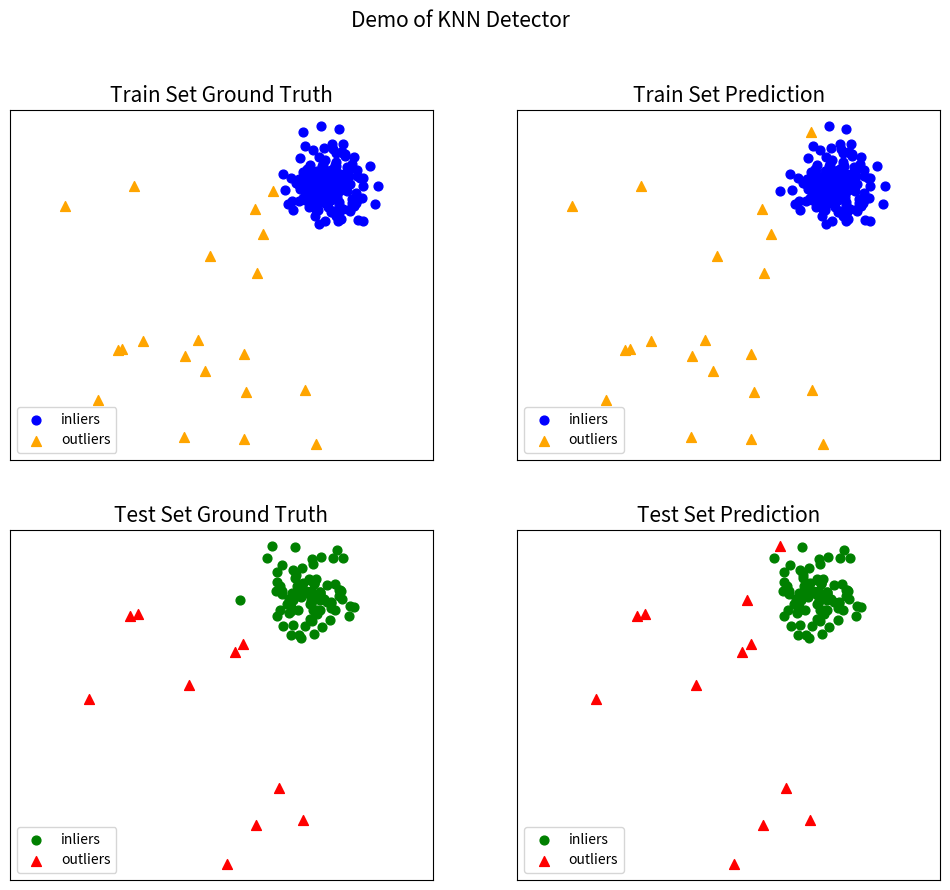

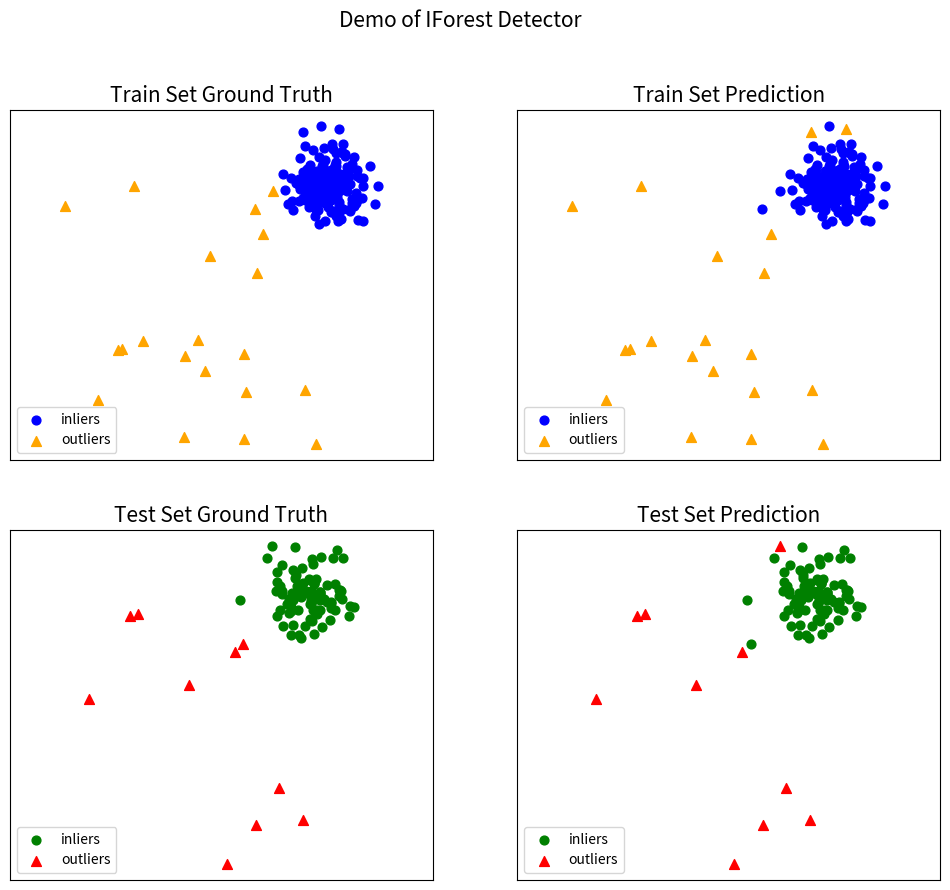

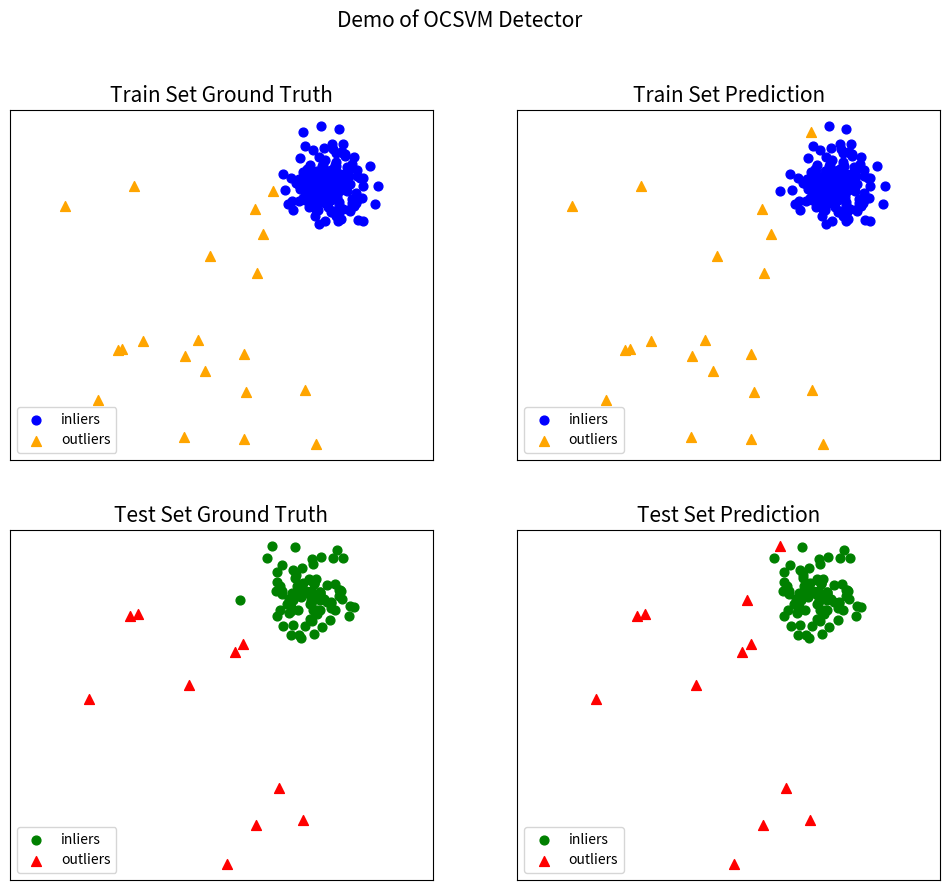

<Figure size 640x480 with 0 Axes>

In [14]:
# fig, axes = plt.subplots(2, 2, figsize=(14, 9))
# axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train) # Predict on training data as well
    visualize(
        clf_name=name,
        X_train=X_train, y_train=y_train,
        X_test=X_test, y_test=y_test,
        y_test_pred=y_pred_test,
        y_train_pred=y_pred_train, # Add y_train_pred
        show_figure=True
    )

plt.suptitle("🧭 四種 PyOD 模型異常邊界比較", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

/tmp/ipython-input-2218730793.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Taipei Sans TC Beta.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Taipei Sans TC Beta.
  fig.canvas.print_figure(bytes_io, **kw)


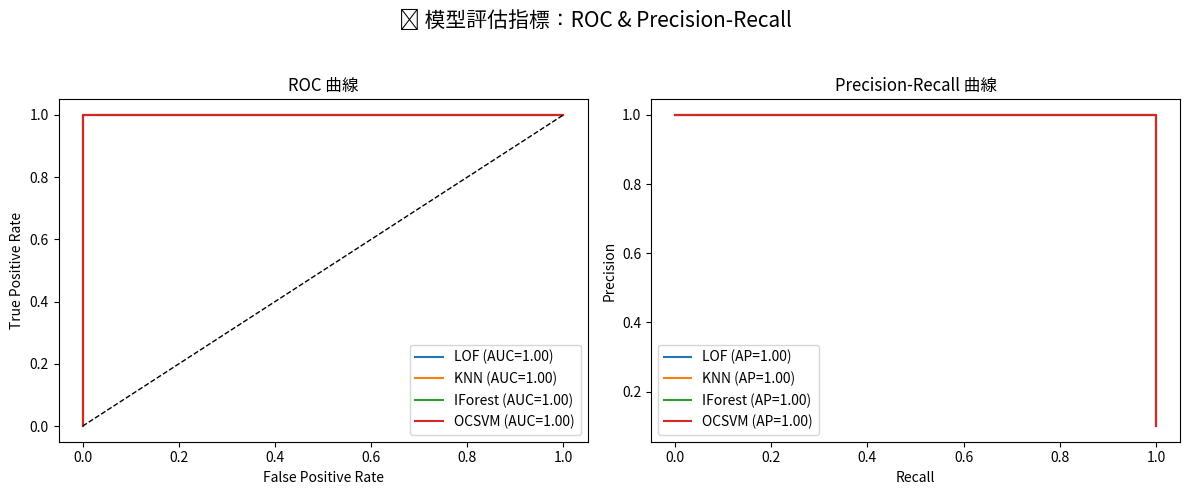

In [15]:
from sklearn.metrics import roc_auc_score, average_precision_score

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

for name, model in models.items():
    model.fit(X_train)
    y_scores = model.decision_function(X_test)

    # ROC 曲線
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_auc = auc(fpr, tpr)
    ax1.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')

    # PR 曲線
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    pr_auc = auc(recall, precision)
    ax2.plot(recall, precision, label=f'{name} (AP={pr_auc:.2f})')

ax1.plot([0, 1], [0, 1], 'k--', lw=1)
ax1.set_title("ROC 曲線")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.legend()

ax2.set_title("Precision-Recall 曲線")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.legend()

plt.suptitle("📊 模型評估指標：ROC & Precision-Recall", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', IForest(contamination=0.05))
])
pipe.fit(X_train)
y_pred = pipe.predict(X_test)